# Naive Bayes Model: Google Play Store Reviews 
## 1. Import Modules 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

## 2. Data Preparation 
### 2.1 Data download from CSV file 

In [2]:
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv')

### 2.2 Data Inspection 

In [3]:
data_df.head().T

,0,1,2,3,4
package_name,com.facebook.katana,com.facebook.katana,com.facebook.katana,com.facebook.katana,com.facebook.katana
review,privacy at least put some option appear offli...,"messenger issues ever since the last update, ...",profile any time my wife or anybody has more ...,the new features suck for those of us who don...,forced reload on uploading pic on replying co...
polarity,0,0,0,0,0


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


- 3 columns with 2 categorical and 1 numeric features and no missing data! 

### 2.3 Train-test split 

In [5]:
training_df, testing_df=train_test_split(data_df, test_size=0.3, random_state=315)

In [6]:
training_df.head().T

,106,4,589,712,592
package_name,com.linkedin.android,com.facebook.katana,com.evernote,com.opera.mini.native,com.evernote
review,why can't i share my achievements? recently d...,forced reload on uploading pic on replying co...,very user friendly! for those looking for a s...,save image and low performance can not save a...,too much going on its cool it works but ony u...
polarity,0,0,1,0,1


### 2.4 Data Encoding 

In [8]:
training_reviews=training_df['review']
testing_reviews=testing_df['review']
training_reviews.head()

106     why can't i share my achievements? recently d...
4       forced reload on uploading pic on replying co...
589     very user friendly! for those looking for a s...
712     save image and low performance can not save a...
592     too much going on its cool it works but ony u...
Name: review, dtype: object

In [9]:
training_reviews.info()

<class 'pandas.core.series.Series'>
Index: 623 entries, 106 to 873
Series name: review
Non-Null Count  Dtype 
--------------  ----- 
623 non-null    object
dtypes: object(1)
memory usage: 9.7+ KB


In [11]:
testing_reviews.info()

<class 'pandas.core.series.Series'>
Index: 268 entries, 393 to 699
Series name: review
Non-Null Count  Dtype 
--------------  ----- 
268 non-null    object
dtypes: object(1)
memory usage: 4.2+ KB


- split of the data set(891): training(623) and testing (268)

In [10]:
vector_model=CountVectorizer(stop_words="english")
vector_model.fit(training_reviews)
training_word_counts=vector_model.transform(training_reviews).toarray()
testing_word_counts=vector_model.transform(testing_reviews).toarray()

print(f'Word count matrix has {training_word_counts.shape[0]} rows and {training_word_counts.shape[1]} columns')

Word count matrix has 623 rows and 3012 columns


In [12]:
training_word_counts[0]


array([0, 0, 0, ..., 0, 0, 0], shape=(3012,))

In [13]:
feature_names=vector_model.get_feature_names_out()
training_word_counts=pd.DataFrame(training_word_counts, columns=feature_names)
testing_word_counts=pd.DataFrame(testing_word_counts, columns=feature_names)
training_word_counts.head().T

,0,1,2,3,4
000,0,0,0,0,0
04,0,0,0,0,0
0x,0,0,0,0,0
10,0,0,0,0,0
100,0,0,0,0,0
...,...,...,...,...,...
żŕ,0,0,0,0,0
żŕľ,0,0,0,0,0
žŕ,0,0,0,0,0
žŕľ,0,0,0,0,0


## 3. EDA 
### 3.1. Baseline model performance 

In [14]:
training_df['polarity'].value_counts()

polarity
0    414
1    209
Name: count, dtype: int64

In [15]:
testing_df['polarity'].value_counts()

polarity
0    170
1     98
Name: count, dtype: int64

In [16]:
training_df['package_name'].value_counts()

package_name
com.evernote                  32
com.Slack                     32
org.mozilla.firefox           31
com.facebook.orca             30
com.android.chrome            30
com.facebook.katana           30
com.hamropatro                29
com.dropbox.android           29
com.king.candycrushsaga       28
com.supercell.clashofclans    28
com.tencent.mm                28
com.google.android.talk       27
com.viber.voip                27
com.hamrokeyboard             27
com.linkedin.android          26
com.imangi.templerun2         26
com.opera.mini.native         26
com.shirantech.kantipur       26
com.rovio.angrybirds          25
com.twitter.android           24
com.whatsapp                  24
com.uc.browser.en             21
jabanaki.todo.todoly          17
Name: count, dtype: int64

Accuracy of a constant '0' model 

In [17]:
accuracy=((len(testing_df) - sum(testing_df['polarity'])) / len(testing_df))*100
print(f'Testing accuracy of constant "0" polarity model: {accuracy:.2f}%')

Testing accuracy of constant "0" polarity model: 63.43%


Logistic Regression Model 

In [18]:
model=LogisticRegression()
model.fit(training_word_counts, training_df['polarity'])

accuracy=accuracy_score(model.predict(testing_word_counts),testing_df['polarity'])

print(f'Testing accuracy of logistic regression model: {accuracy*100:.1f}%')

Testing accuracy of logistic regression model: 78.4%


In [19]:
lengths=training_df['review'].str.len().tolist()
print(lengths)

[160, 466, 209, 151, 488, 228, 210, 307, 208, 477, 209, 200, 457, 463, 111, 212, 123, 130, 378, 364, 115, 181, 262, 333, 212, 220, 370, 149, 344, 43, 233, 289, 38, 160, 154, 34, 174, 110, 380, 242, 217, 184, 228, 275, 230, 237, 168, 21, 147, 429, 198, 292, 358, 395, 150, 42, 261, 302, 273, 141, 510, 165, 79, 366, 168, 198, 141, 366, 156, 288, 8, 374, 56, 423, 233, 268, 111, 148, 129, 106, 35, 195, 106, 185, 176, 286, 325, 175, 15, 125, 196, 181, 106, 164, 265, 531, 287, 81, 192, 158, 233, 53, 216, 86, 145, 167, 222, 220, 236, 389, 282, 138, 440, 198, 249, 201, 258, 161, 198, 168, 136, 209, 116, 163, 212, 342, 152, 274, 516, 160, 156, 162, 331, 224, 79, 142, 419, 115, 192, 115, 126, 443, 118, 175, 253, 314, 46, 190, 177, 257, 197, 444, 286, 404, 287, 459, 205, 217, 242, 273, 218, 219, 222, 210, 282, 465, 163, 341, 83, 157, 160, 231, 402, 500, 26, 151, 225, 155, 135, 151, 223, 133, 386, 347, 173, 202, 184, 133, 253, 269, 25, 159, 308, 53, 510, 525, 71, 211, 217, 171, 483, 535, 281, 196, 

### 3.2 Review Length Distributions 

Mean of Review length: 227
Min count of Review length: 8
Max count of Review length: 910


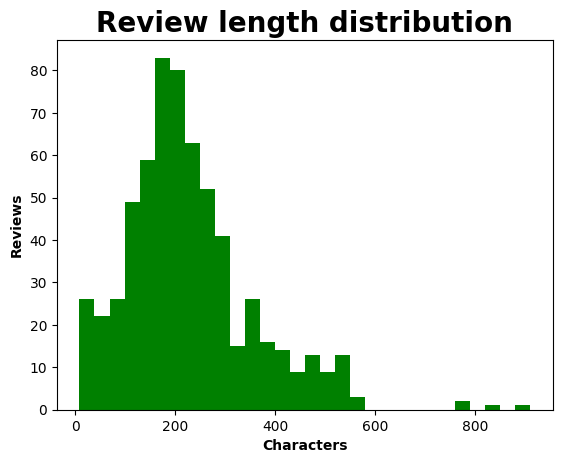

In [20]:
lengths=training_df['review'].str.len().tolist()
print(f'Mean of Review length: {np.mean(lengths):.0f}')
print(f'Min count of Review length: {min(lengths):.0f}')
print(f'Max count of Review length: {max(lengths):.0f}')

plt.title('Review length distribution', fontsize=20, fontweight='bold')
plt.xlabel('Characters', fontweight='bold')
plt.ylabel('Reviews', fontweight='bold')
plt.hist(lengths, bins=30, color='green')
plt.show()



#### 3.2.1 Inspect Long reviews 

In [21]:
training_df['review_length']=lengths
long_reviews=training_df[training_df['review_length'] > 600]

In [22]:
print(long_reviews['review'].iloc[0])

  ătoo slow loading webclips!!! ăno pdf support at all... (even simpler apps do that!) ă web pages that are clipped do not adjust to current window size automatically when window is shrunk or expanded, (any program does this...geez). ă highlighting? needs more colors instead of brown mustard yellow. no customer support responses either, evernote must have been taken over by students. it's not even fun to use anymore because it is slow as hell.  this is especially for serious business users. any five star ratings down here must have been given by employees under different themes. this program has really retarded over the years. they need to stick to improving their bread and butter instead of selling side junk and features that are useless. well they got my money this time, so i have to put up with it for a few more months. the lack of pdf support really is terrible for a program like this.


In [23]:
print(long_reviews['review'].iloc[1])

  not since the update i don't.                                  update:- it is very slow on both data (uk ee network) and wifi (all of home via bt /work network/london underground virgin network) on all devices. version number is 13.0.2036.98649 on each device.  practically unusable at present and everything was fine before upgrading.  reading other comments i'm far from the only one having problems. high and low quality images helps but it is still worse than before the upgrade.  and just discovered that previously a double tap enlarged the text sufficiently to make it readable.  now it enlarges it a tiny amount but pinch and zoom is still required.    why did you do this?  the good old adage 'if it ain't broke don't fix it absolutely comes to mind.


In [24]:
print(long_reviews['review'].iloc[2])

 bait and switch i purchased my 3rd samsung tablet with  advertisement of free gifts, one of them being 48 additional gb cloud storage for 2 years.  the 2nd samsung tablet i bought also had this free gift and it was a nightmare to get samsung and dropbox to honor it.  so, after buying this 3rd high end tablet with the same claim of the free 48gb for 2 years in the fine print, which you can only see after purchasing the tablet, dropbox only honors the offer on the first device you purchased and you are disqualified for all future devices.  this is sleazy and bait and switch.  free= not subject to any compensation, encumbrance, repayment in kind, etc.  because of this bait and switch advertising on the part of samsung and dropbox i suggest you really find out what kind of company dropbox is before using their services.


In [26]:
print(long_reviews['review'].iloc[3])

 the best game about they dont call this the no.1 app for nothing, its the original and best clean game about. one needs to work out how best to strike the piggy structures by flinging the birds in a sling (funny though, i thought they had wings). it is a wonderful novel idea for a game and will no doubt will continue to appeal to a wide audience for some time to come! (it's as big as what the old lemmings game was in the 1990s) it's so addictive and fun to play whilst having a good feel about it. for me beats angry birds 2 game very easily and will no doubt remain so for the near future. the only flaw in it is loads of adds and becomes so slow when connected to the internet, but thankfully, the in game adds can be binned for a small fee but it also plays fine offline.


#### 3.2.2 Inspect Short reviews 

In [29]:
short_reviews=training_df[training_df['review_length'] < 30]
short_reviews.head()

,package_name,review,polarity,review_length
755,com.shirantech.kantipur,too much pop up add,0,21
761,com.shirantech.kantipur,aa nice,1,8
851,com.hamropatro,very useful !,1,15
511,com.Slack,love new material design,1,26
840,com.hamropatro,usefully verry nice app,1,25


### 3.3 Feature selection 

In [36]:
word_counts=training_word_counts.sum().tolist()
print(word_counts)

[1, 1, 1, 9, 3, 1, 1, 1, 1, 1, 3, 1, 1, 4, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 1, 2, 1, 3, 1, 6, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 5, 29, 1, 4, 1, 1, 1, 1, 6, 2, 2, 1, 1, 1, 1, 10, 1, 1, 1, 2, 1, 3, 3, 1, 1, 9, 6, 1, 1, 30, 9, 1, 1, 4, 6, 1, 1, 1, 3, 1, 9, 1, 2, 1, 1, 1, 34, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 3, 1, 2, 1, 2, 1, 1, 1, 1, 8, 3, 5, 2, 2, 1, 9, 1, 2, 1, 1, 1, 1, 40, 12, 2, 1, 2, 2, 2, 16, 1, 2, 1, 1, 2, 2, 1, 2, 15, 3, 1, 1, 1, 2, 1, 1, 318, 1, 2, 1, 7, 2, 2, 9, 5, 1, 17, 1, 1, 1, 1, 1, 1, 1, 37, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 5, 1, 1, 2, 3, 4, 3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 4, 2, 1, 5, 1, 1, 1, 19, 1, 1, 17, 5, 1, 1, 11, 21, 1, 3, 1, 1, 1, 2, 13, 2, 5, 1, 12, 1, 3, 1, 1, 1, 1, 6, 1, 1, 1, 1, 5, 1, 4, 7, 5, 1, 5, 8, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 41, 4, 33, 1, 1, 1, 16, 1, 1, 1, 1, 1, 4, 16, 3, 11, 5, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 5

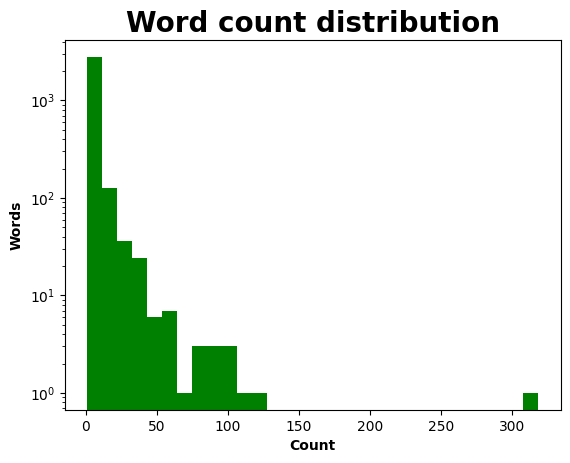

In [37]:
plt.title('Word count distribution', fontsize=20, fontweight='bold')
plt.xlabel('Count', fontweight='bold')
plt.ylabel('Words', fontweight='bold')
plt.hist(word_counts, bins=30, color='green')
plt.yscale('log')
plt.show()

## 4. Model comparison 

In [39]:
cross_val_scores={'Model': [], 'Score': []}

### 4.1 Gaussian Naive Bayes 

In [40]:
scores=cross_val_score(GaussianNB(), training_word_counts,
    training_df['polarity'], cv=7, n_jobs=-1)

cross_val_scores['Model'].extend(['Gaussian Naive Bayes']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 75.0 +/- 2.8%


### 4.2 Multinomial Naive Bayes 

In [41]:
scores=cross_val_score(MultinomialNB(), training_word_counts,
    training_df['polarity'], cv=7, n_jobs=-1)

cross_val_scores['Model'].extend(['Multinomial Naive Bayes']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 81.5 +/- 4.9%


### 4.3 Bernoulli Naive Bayes 

In [42]:
scores=cross_val_score(BernoulliNB(), training_word_counts,
    training_df['polarity'], cv=7, n_jobs=-1)

cross_val_scores['Model'].extend(['Bernoulli Naive Bayes']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 74.5 +/- 4.1%


In [45]:
print(cross_val_scores)

{'Model': ['Gaussian Naive Bayes', 'Gaussian Naive Bayes', 'Gaussian Naive Bayes', 'Gaussian Naive Bayes', 'Gaussian Naive Bayes', 'Gaussian Naive Bayes', 'Gaussian Naive Bayes', 'Multinomial Naive Bayes', 'Multinomial Naive Bayes', 'Multinomial Naive Bayes', 'Multinomial Naive Bayes', 'Multinomial Naive Bayes', 'Multinomial Naive Bayes', 'Multinomial Naive Bayes', 'Bernoulli Naive Bayes', 'Bernoulli Naive Bayes', 'Bernoulli Naive Bayes', 'Bernoulli Naive Bayes', 'Bernoulli Naive Bayes', 'Bernoulli Naive Bayes', 'Bernoulli Naive Bayes'], 'Score': [np.float64(74.15730337078652), np.float64(73.03370786516854), np.float64(77.52808988764045), np.float64(76.40449438202246), np.float64(75.28089887640449), np.float64(78.65168539325843), np.float64(69.66292134831461), np.float64(78.65168539325843), np.float64(89.8876404494382), np.float64(75.28089887640449), np.float64(80.89887640449437), np.float64(85.39325842696628), np.float64(76.40449438202246), np.float64(84.26966292134831), np.float64(78

### 4.4 Cross-validation performance 

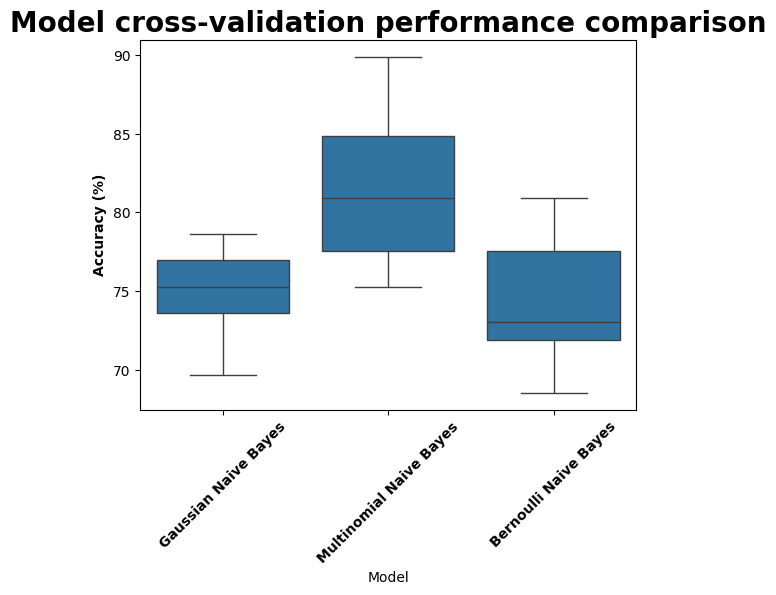

In [47]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison', fontsize=20, fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.xticks(rotation=45, fontweight='bold')
plt.show()

## 5. Final model evaluation 

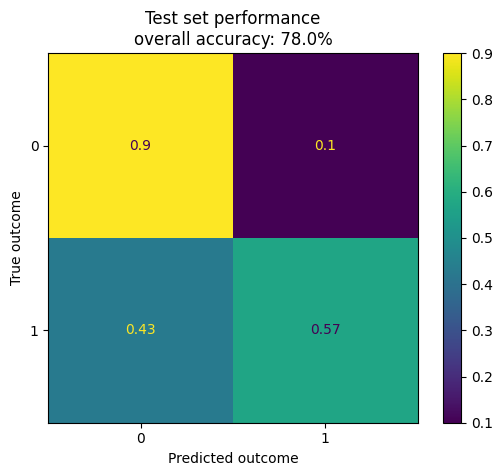

In [55]:
model=MultinomialNB()
model.fit(training_word_counts, training_df['polarity'])
testing_predictions=model.predict(testing_word_counts)
accuracy=accuracy_score(testing_predictions, testing_df['polarity'])*100

# Plot the confusion matrix
cm=confusion_matrix(testing_df['polarity'], testing_predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()